# The Shakes

Copyright 2020 Allen Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

*The Shakes* is a dice game that demonstrates Thompson sampling, also known as the Bayesian Bandit strategy.

[The rules of the game are here](https://allendowney.github.io/TheShakes/)

This notebook explains how the game works, and especially how the part of the game called "The Argument" uses dice to approximate Thompson sampling.

The steps of Thompson sampling are:

1. Use past results to compute the posterior distribution of efficacy for each treatment.

2. Draw a random sample from each posterior distribution.

3. Use whichever treatment draws the highest efficacy.

To understand the first step, we'll start with the beta distribution.

Here are the libraries we need.

In [1]:
# If we're running on Colab, install empiricaldist
# https://pypi.org/project/empiricaldist/

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from empiricaldist import Pmf, Cdf

## The beta distribution



Suppose we have used one of the treatments 7 times and saved 2 patients.

In [3]:
treated = 7
saved = 2

Assuming that the prior distribution is uniform from 0 to 1, the posterior distribution is beta with parameters `alpha = saved+1` and `beta = treated-saved+1`.

We can use SciPy to represent this distribution.

In [4]:
from scipy.stats import beta

dist = beta(saved+1, treated-saved+1)

To plot the distribution, I'll make a `Pmf` with a discrete approximation.

In [5]:
qs = np.linspace(0, 1, 101)
ps = dist.pdf(qs)

pmf_beta = Pmf(ps, qs)
pmf_beta.normalize()

99.9999930006

Here's what it looks like.

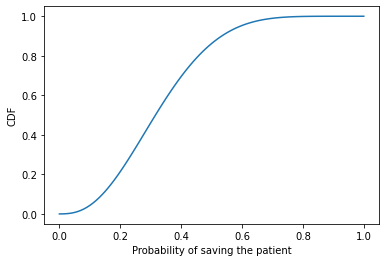

In [6]:
pmf_beta.make_cdf().plot()

plt.xlabel('Probability of saving the patient')
plt.ylabel('CDF');

Based on two survivors out of 7 patients, we think the efficacy of this treatment is low, but it could still be as high as 50% or 60%.

## Random sampling

The second step of Thompson sampling is to draw a random value from each posterior distribution.

There are several ways to generate beta-distributed random variables, but one in particular is amenable to being implemented with dice.  According to [Wikipedia](https://en.wikipedia.org/wiki/Beta_distribution#Generating_beta-distributed_random_variates):

> ... the kth order statistic of n uniformly distributed variates is $\mathrm {B} (k,n+1-k)$, so an alternative if α and β are small integers is to generate α + β − 1 uniform variates and choose the α-th smallest.

Wikipedia cites
David and Nagaraja, [Order Statistics](https://www.wiley.com/en-us/Order+Statistics%2C+3rd+Edition-p-9780471389262).

But don't take their word for it; let's test it.

The following function takes the number of patients treated and the number saved.

It generates `treated+1` random values between 0 and 1, then selects the one with index `saved`.

In [7]:
def uniform(treated, saved):
    """Draw uniform values and select the given rank.
    
    treated: number of patients treated
    saved: number saved
    
    returns: random value between 0 and 1
    """
    rolls = np.random.random(size=treated+1)
    kth = np.sort(rolls)[saved]
    return kth

Here's a sample of 10,000 values.

In [8]:
sample = [uniform(treated, saved) for _ in range(10_000)]

And here's their distribution compared to the beta distribution

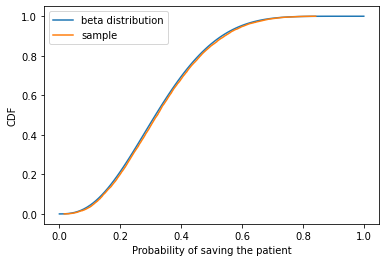

In [9]:
cdf = Cdf.from_seq(sample)

pmf_beta.make_cdf().plot(label='beta distribution')
cdf.plot(label='sample')

plt.xlabel('Probability of saving the patient')
plt.ylabel('CDF')
plt.legend();

The agreement is pretty good, although there might be a small difference between the beta distribution and the sample.

## Rolling Dice

The result of rolling a single die is uniformly distributed, so we can use dice to sample from a beta distribution, or at least a discrete approximation of one.

The following function takes the number of patients treated, the number saved, and the number of sides on the die.

It simulates the following steps:

1. Roll one die plus one for each patient treated.

2. Starting with the lowest die and working up, remove one die for each patient saved.

3. Report the lowest of the remaining dice.



In [10]:
def roll_dice(treated, saved, sides=6):
    """Simulate dice rolls and select the given rank.
    
    treated: number of patients treated
    saved: number saved
    sides: number of sides on the dice
    
    returns: random integer between 1 and sides (including both)
    """
    rolls = np.random.randint(1, sides+1, size=treated+1)
    kth = np.sort(rolls)[saved]
    return kth

Here's a sample of results using 6-sided dice.

In [11]:
sides = 6

rolls = [roll_dice(treated, saved, sides) / sides
         for _ in range(10_000)]

Here's what the distribution of results looks like, compared to the actual beta distribution.

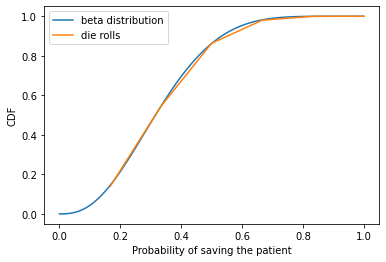

In [12]:
cdf = Cdf.from_seq(rolls)

pmf_beta.make_cdf().plot(label='beta distribution')
cdf.plot(label='die rolls')

plt.xlabel('Probability of saving the patient')
plt.ylabel('CDF')
plt.legend();

The distribution of the sample is a good (albeit coarse) approximation of the beta distribution.

## Simulating the game

We can use `roll_dice` to simulate the game.

The following function creates a `DataFrame` to represent the score sheet.

In [13]:
def initialize(treatments, efficacy):
    df = pd.DataFrame(index=treatments)
    df['efficacy'] = efficacy
    df['treated'] = 0
    df['saved'] = 0
    return df

Here's an example with four treatments and their corresponding efficacies:

In [14]:
treatments = ['peppers', 'venom', 'blood', 'fire']
np.random.shuffle(treatments)

efficacy = [4, 2, 1, 1]

In [15]:
df = initialize(treatments, efficacy)
df

,efficacy,treated,saved
blood,4,0,0
fire,2,0,0
venom,1,0,0
peppers,1,0,0


In [16]:
def argue(df):
    res = pd.Series(0, index=df.index)
    for treatment in df.index:
        saved = df.loc[treatment, 'saved']
        treated = df.loc[treatment, 'treated']
        res[treatment] = roll_dice(treated, saved)
    return res

In [17]:
strength = argue(df)
strength

blood      5
fire       1
venom      6
peppers    2
dtype: int64

In [18]:
def choose(strength):
    """Choose the strongest argument
    
    strength: Series of strength scores
    
    returns: an element from the index of strength
    """
    # make a copy of the strength column and shuffle it
    # so ties are broken randomly
    shuffled = strength.sample(frac=1)
    
    # return the treatment whose argument is strongest
    return shuffled.idxmax()

In [19]:
t = choose(strength)
t

'venom'

In [20]:
def treat(df, treatment):
    """Simulate treating a patient.
    
    df: DataFrame representing the 
    
    The probability of survival depends on the efficacy 
    of the treatment.
    """
    eff = df.loc[treatment, 'efficacy']
    df.loc[treatment, 'treated'] += 1
    survived = np.random.randint(1, 7) <= eff
    if survived:
        df.loc[treatment, 'saved'] += 1
    return survived

In [21]:
treat(df, t)

False

In [22]:
df

,efficacy,treated,saved
blood,4,0,0
fire,2,0,0
venom,1,1,0
peppers,1,0,0


In [23]:
def simulate(treatments, efficacy, num_rounds=18):
    """Simulate the game.
    
    treatments: sequence of strings
    efficacy: sequence of integers 1-6
    num_round: how many rounds to play
    
    returns: DataFrame with the results
    """
    np.random.shuffle(treatments)
    df = initialize(treatments, efficacy)

    for _ in range(num_rounds):
        strength = argue(df)
        t = choose(strength)
        survived = treat(df, t)
        
    return df

In [24]:
df = simulate(treatments, efficacy)
df

,efficacy,treated,saved
peppers,4,9,5
venom,2,2,0
blood,1,5,2
fire,1,2,0


To summarize the results, display the total number saved and the number treated.

In [25]:
def totals(df):
    return df['saved'].sum(), df['treated'].sum()

In [26]:
totals(df)

(7, 18)

Simulate many games and record the outcomes.

In [27]:
num_saved = []
max_dice = []

for _ in range(1000):
    df = simulate(treatments, efficacy)
    num_saved.append(df['saved'].sum())
    max_dice.append(df['treated'].max())

Here's the distribution of the number of patients saved.

Text(0, 0.5, 'PMF')

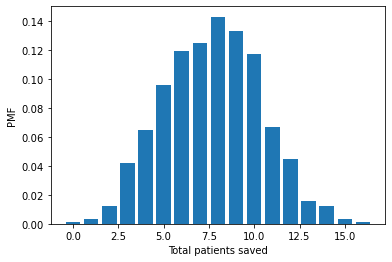

In [28]:
pmf = Pmf.from_seq(num_saved)
pmf.bar()

plt.xlabel('Total patients saved')
plt.ylabel('PMF')

The players win about 70% of the time.

In [29]:
pmf.gt_dist(6)

0.662

Here's the distribution for the maximum number of dice we need.

Text(0, 0.5, 'PMF')

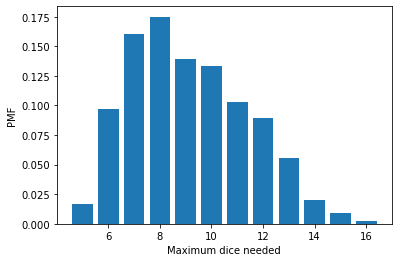

In [30]:
pmf = Pmf.from_seq(max_dice)
pmf.bar()

plt.xlabel('Maximum dice needed')
plt.ylabel('PMF')

In [31]:
(np.array(max_dice) > 10).mean()

0.279